In [4]:
import os
import time
import copy
import glob
import cv2
import shutil
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models # for transfer learning
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [5]:
!cp -r ../input/catanddog-simple /kaggle/working

In [6]:
data_path = './catanddog-simple/catanddog/train'

transform = transforms.Compose(
                    [
                        transforms.Resize([256, 256]),
                        transforms.RandomResizedCrop(224), # 랜덤하게 해당 사이즈의 이미지로 크롭
                        transforms.RandomHorizontalFlip(), 
                        transforms.ToTensor() # 이미지 데이터를 텐서로 변환
                    ])
train_dataset = torchvision.datasets.ImageFolder( # 데이터로더가 데이터를 불러올 대상(경로)와 방법(or 전처리)을 정의.
                    data_path,
                    transform = transform
)
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size = 32,
                    num_workers = 8,
                    shuffle = True
)

print(len(train_dataset))

385


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


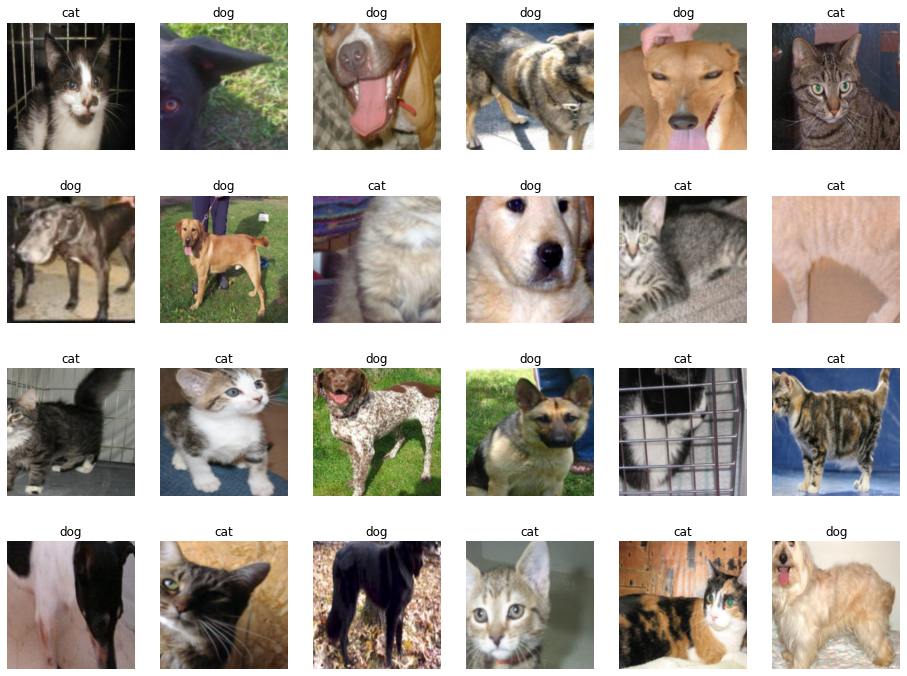

In [7]:
samples, labels = iter(train_loader).next()
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize = (16, 24))
for i in range(24):
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()]) # 레이블 정보를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0))) #np.transpose를 통해 (3, 224, 244) -> (224, 224, 3) shape으로 변경

plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)
    

In [8]:
resnet18 = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
def set_parameter_requires_grad(model, feature_extracting = True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

In [10]:
resnet18.fc = nn.Linear(512, 2)

for name, param in resnet18.named_parameters(): # model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0261, -0.0171, -0.0025,  ..., -0.0347, -0.0297, -0.0202],
        [-0.0025, -0.0439, -0.0012,  ..., -0.0310, -0.0211,  0.0078]])
fc.bias tensor([0.0268, 0.0054])


In [11]:
model = models.resnet18(pretrained = True) # 모델의 객체 생성 

for param in model.parameters():
    param.requires_grad = False # 역전파 과정에서 파라미터들에 대한 변화를 계산할 필요가 없음을 명시한다.
    
model.fc = torch.nn.Linear(512, 2) # Fully Connected Layer를 마지막에 추가해서 classifying layer로 활용
for param in model.fc.parameters(): # 완전 연결층은 학습 ON
    param.requires_grad = True
    
optimizer = torch.optim.Adam(model.fc.parameters()) # 현재 FC layer에 대한 파라미터만 업데이트 해주면 됨
cost = torch.nn.CrossEntropyLoss()
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 모델 학습을 위한 함수 생성

In [28]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 20, is_train = True):
    since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders: # 데이터로더에 전달된 데이터만큼 반복 ON
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad() # 기울기를 0으로 설정, 기울기 초기화. <- 없으면 loss.backward()에서 새로운 기울기 값이 이전 기울기 값에 누적하여 계산된다.
            outputs = model(inputs) # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1) # preds에 max를 통해 나온 값들의 indices를 저장.
            loss.backward()
            optimizer.step() # 전달받은 파라미터들을 업데이트
            
            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장.
            running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적항 ㅕ저장.
            
        
        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산.
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산
        
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item()) # epoch_acc를 구하는 running_corrects가 torch.sum연산으로 계산되었기 때문에 1개의 요소를 가지는 텐서로부터 item()을 사용하여 값을 추출해낸다.
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('./catanddog-simple/catanddog/','{0:0=2d}.pth'.format(epoch)))
        print()
                                                    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history
        
        
        
        

In [29]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)
        
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


## 모델 학습

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/19
----------
Loss: 0.2617 Acc: 0.9091

Epoch 1/19
----------
Loss: 0.2066 Acc: 0.9143

Epoch 2/19
----------
Loss: 0.1948 Acc: 0.9273

Epoch 3/19
----------
Loss: 0.2131 Acc: 0.9039

Epoch 4/19
----------
Loss: 0.1721 Acc: 0.9247

Epoch 5/19
----------
Loss: 0.1957 Acc: 0.9169

Epoch 6/19
----------
Loss: 0.1419 Acc: 0.9351

Epoch 7/19
----------
Loss: 0.1487 Acc: 0.9429

Epoch 8/19
----------
Loss: 0.1231 Acc: 0.9636

Epoch 9/19
----------
Loss: 0.1460 Acc: 0.9351

Epoch 10/19
----------
Loss: 0.1476 Acc: 0.9351

Epoch 11/19
----------
Loss: 0.1288 Acc: 0.9532

Epoch 12/19
----------
Loss: 0.1493 Acc: 0.9429

Epoch 13/19
----------
Loss: 0.1081 Acc: 0.9662

Epoch 14/19
----------
Loss: 0.1062 Acc: 0.9584

Epoch 15/19
----------
Loss: 0.1180 Acc: 0.9481

Epoch 16/19
----------
Loss: 0.1175 Acc: 0.9584

Epoch 17/19
----------
Loss: 0.1486 Acc: 0.9481

Epoch 18/19
----------
Loss: 0.1274 Acc: 0.9481

Epoch 19/19
----------
Loss: 0.1518 Acc: 0.9351

Training complete in 6m 21s
Be

In [31]:
test_path = './catanddog-simple/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers = 1,
    shuffle = False
)

print(len(test_dataset))

98


## 테스트 데이터 평가 함수 생성

In [42]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0
    
    saved_models = glob.glob('./catanddog-simple/catanddog/' + '*.pth') 
    saved_models.sort() # 불러온 .pth 파일들을 정렬
    print('saved_model', saved_models)
    for model_path in saved_models:
        print('Loading model', model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad(): # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs) # 데이터를 모델에 적용한 결과를 outputs에 저장
                
            _, preds = torch.max(outputs.data, 1) # 최대인 indeces를 저장
            preds[preds >= 0.5] = 1 # torch.max로 출력된 값이 0.5 이상이면 올바르게 예측
            preds[preds < 0.5] = 0 
            running_corrects += preds.eq(labels.cpu()).int().sum() # preds.eq(labels)는 preds 배열과 labels가 일치하는지 검사. 또한, 뒤에 사용된
            #.sum()은 모델의 예측 결과와 정답 레이블이 일치하는 것들의 개수 합을 숫자로 출력
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
            
        if epoch_acc > best_acc:
             best_acc = epoch_acc
                
        acc_history.append(epoch_acc.item())
        print()
            
        
    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
        
    return acc_history

In [43]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./catanddog-simple/catanddog/00.pth', './catanddog-simple/catanddog/01.pth', './catanddog-simple/catanddog/02.pth', './catanddog-simple/catanddog/03.pth', './catanddog-simple/catanddog/04.pth', './catanddog-simple/catanddog/05.pth', './catanddog-simple/catanddog/06.pth', './catanddog-simple/catanddog/07.pth', './catanddog-simple/catanddog/08.pth', './catanddog-simple/catanddog/09.pth', './catanddog-simple/catanddog/10.pth', './catanddog-simple/catanddog/11.pth', './catanddog-simple/catanddog/12.pth', './catanddog-simple/catanddog/13.pth', './catanddog-simple/catanddog/14.pth', './catanddog-simple/catanddog/15.pth', './catanddog-simple/catanddog/16.pth', './catanddog-simple/catanddog/17.pth', './catanddog-simple/catanddog/18.pth', './catanddog-simple/catanddog/19.pth']
Loading model ./catanddog-simple/catanddog/00.pth
Acc: 0.9490

Loading model ./catanddog-simple/catanddog/01.pth
Acc: 0.9592

Loading model ./catanddog-simple/catanddog/02.pth
Acc: 0.9490

Loading model ./ca

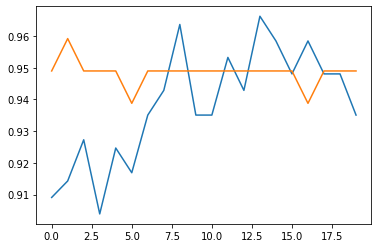

In [44]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()


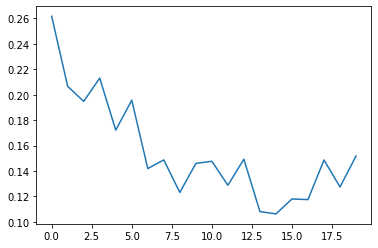

In [45]:
plt.plot(train_loss_hist)
plt.show()

In [63]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # tensor.clone()으로 기존 텐서의 내용을 복사한 텐서를 생성하고, detach()를 통해서 기존 텐서에서 기울기를 전파하지 않는다. -> 복사해서 새로운 텐서를 생성하지만, 기울기에는 영향을 주지 않겠따.
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))) # 값의 범위가 -1 +1 이라면 위의 전처리로 0,1 범위로 조정.
    image = image.clip(0, 1) # image 데이터를 0과 1 사이의 값으로 제한
    return image

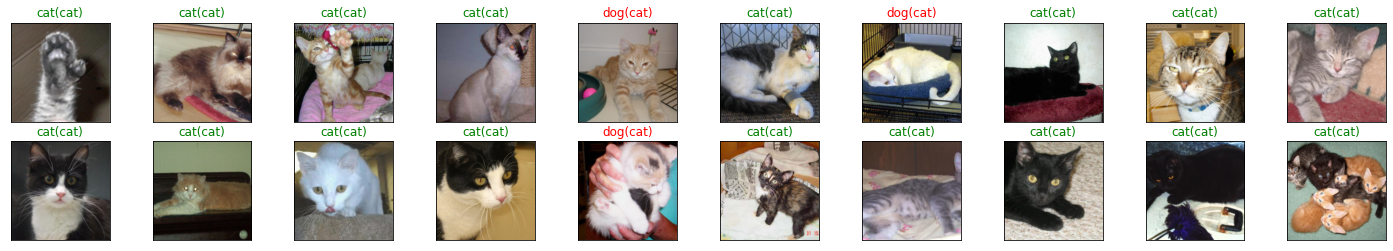

<Figure size 432x288 with 0 Axes>

In [67]:
classes = {0: 'cat', 1: 'dog'}

dataiter = iter(test_loader) # 테스트 데이터셋을 가져온다.
images, labels = dataiter.next() # 테스트 데이터셋으로부터 이미지와 레이블을 분리하여 가져온다.
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx] == labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)